In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display, HTML
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses

# recommenders
from recommenders.recommender import Recommender
from recommenders.amazon_recommender import AmazonRecommender
from recommenders.netflix_recommender import NetflixRecommender

# evaluation
from evaluation_and_testing.testing import evaluate_train_test_split_implicit

# tunning
from hyperopt import hp, fmin, tpe, Trials
import traceback

from collections import defaultdict, deque

# Fix the dying kernel problem (only a problem in some installations - you can remove it, if it works without it)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

d:\Dev\Anaconda\envs\rs_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the dataset for recommenders

In [2]:
data_path = os.path.join("data", "hotel_data")

interactions_df = pd.read_csv(os.path.join(data_path, "hotel_data_interactions_df.csv"), index_col=0)

base_item_features = ['term', 'length_of_stay_bucket', 'rate_plan', 'room_segment', 'n_people_bucket', 'weekend_stay']

column_values_dict = {
    'term': ['WinterVacation', 'Easter', 'OffSeason', 'HighSeason', 'LowSeason', 'MayLongWeekend', 'NewYear', 'Christmas'],
    'length_of_stay_bucket': ['[0-1]', '[2-3]', '[4-7]', '[8-inf]'],
    'rate_plan': ['Standard', 'Nonref'],
    'room_segment': ['[0-160]', '[160-260]', '[260-360]', '[360-500]', '[500-900]'],
    'n_people_bucket': ['[1-1]', '[2-2]', '[3-4]', '[5-inf]'],
    'weekend_stay': ['True', 'False']
}

interactions_df.loc[:, 'term'] = pd.Categorical(
    interactions_df['term'], categories=column_values_dict['term'])
interactions_df.loc[:, 'length_of_stay_bucket'] = pd.Categorical(
    interactions_df['length_of_stay_bucket'], categories=column_values_dict['length_of_stay_bucket'])
interactions_df.loc[:, 'rate_plan'] = pd.Categorical(
    interactions_df['rate_plan'], categories=column_values_dict['rate_plan'])
interactions_df.loc[:, 'room_segment'] = pd.Categorical(
    interactions_df['room_segment'], categories=column_values_dict['room_segment'])
interactions_df.loc[:, 'n_people_bucket'] = pd.Categorical(
    interactions_df['n_people_bucket'], categories=column_values_dict['n_people_bucket'])
interactions_df.loc[:, 'weekend_stay'] = interactions_df['weekend_stay'].astype('str')
interactions_df.loc[:, 'weekend_stay'] = pd.Categorical(
    interactions_df['weekend_stay'], categories=column_values_dict['weekend_stay'])

display(HTML(interactions_df.head(15).to_html()))

,user_id,item_id,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,0,WinterVacation,[2-3],Standard,[260-360],[5-inf],True
1,2,1,WinterVacation,[2-3],Standard,[160-260],[3-4],True
2,3,2,WinterVacation,[2-3],Standard,[160-260],[2-2],False
3,4,3,WinterVacation,[4-7],Standard,[160-260],[3-4],True
4,5,4,WinterVacation,[4-7],Standard,[0-160],[2-2],True
5,6,5,Easter,[4-7],Standard,[260-360],[5-inf],True
6,7,6,OffSeason,[2-3],Standard,[260-360],[5-inf],True
7,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True
8,9,8,HighSeason,[2-3],Standard,[0-160],[1-1],True
9,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True


## Numerical item and user features

I removed optional parts with extracting numerical item and user features as I didn't use them anywhere in project. I spent some time on research about hybrid recommenders because I wanted to learn something about it but finally I decided to focus only on neural network models and optimizers because the size of project is already large and the tuning of so many combinations also required a lot of time.

# Neural network recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Code a recommender based on a neural network model. You are free to choose any network architecture you find appropriate. The network can use the interaction vectors for users and items, embeddings of users and items, as well as user and item features (you can use the features you developed in the first project).

Remember to keep control over randomness - in the init method add the seed as a parameter and initialize the random seed generator with that seed (both for numpy and pytorch):

```python
self.seed = seed
self.rng = np.random.RandomState(seed=seed)
```
in the network model:
```python
self.seed = torch.manual_seed(seed)
```

You are encouraged to experiment with:
  - the number of layers in the network, the number of neurons and different activation functions,
  - different optimizers and their parameters,
  - batch size and the number of epochs,
  - embedding layers,
  - content-based features of both users and items.

## MLP Model

In [3]:
class MLPModel(nn.Module):
    def __init__(self, n_items, n_users, embedding_dim, hidden_dim, seed):
        """
        :param int n_items: Number of items.
        :param int n_users: Number of users.
        :param int embedding_dim: Dimension of the user and item embeddings.
        :param int hidden_dim: Dimension of the first hidden layer.
        :param int seed: Seed for the random number generator.
        """
        super().__init__()

        self.seed = torch.manual_seed(seed)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.nn1 = nn.Linear(2 * embedding_dim, hidden_dim, bias=True)
        self.nn2 = nn.Linear(hidden_dim, int(hidden_dim / 2), bias=True)
        self.nn3 = nn.Linear(int(hidden_dim / 2), 1, bias=False)

    def forward(self, x):
        user = x[:, 0]
        item = x[:, 1]
        user_embedding = self.user_embedding(user)
        item_embedding = self.item_embedding(item)
        x = torch.cat([user_embedding, item_embedding], dim=1)
        x = torch.relu(self.nn1(x))
        x = torch.relu(self.nn2(x))
        x = torch.sigmoid(self.nn3(x))


        return x

## NeuMF Model

In [4]:
class NeuMFModel(nn.Module):
    def __init__(self, n_items, n_users, gmf_embedding_dim, mlp_embedding_dim, hidden_dim, seed):
        """
        :param int n_items: Number of items.
        :param int n_users: Number of users.
        :param int embedding_dim: Dimension of the user and item embeddings.
        :param int hidden_dim: Dimension of the first hidden layer of the MLP part of the network.
        :param int seed: Seed for the random number generator.
        """
        super().__init__()

        self.seed = torch.manual_seed(seed)
        
        self.gmf_user_embedding = nn.Embedding(n_users, gmf_embedding_dim)
        self.gmf_item_embedding = nn.Embedding(n_items, gmf_embedding_dim)

        self.mlp_user_embedding = nn.Embedding(n_users, mlp_embedding_dim)
        self.mlp_item_embedding = nn.Embedding(n_items, mlp_embedding_dim)
        self.mlp_nn1 = nn.Linear(2 * mlp_embedding_dim, hidden_dim, bias=True)
        self.mlp_nn2 = nn.Linear(hidden_dim, int(hidden_dim / 2), bias=True)
        
        self.nn = nn.Linear(gmf_embedding_dim + int(hidden_dim / 2), 1, bias=False)

    def forward(self, x):
        """
        :param torch.Tensor x: Tensor of size batch_size x 2. Every row contains two values - user id in the first column 
            and item id in the second column.
        """
        
        user = x[:, 0]
        item = x[:, 1]
        
        gmf_user_embedding = self.gmf_user_embedding(user)
        gmf_item_embedding = self.gmf_item_embedding(item)
        gmf_x = gmf_user_embedding * gmf_item_embedding
        
        mlp_user_embedding = self.mlp_user_embedding(user)
        mlp_item_embedding = self.mlp_item_embedding(item)
        mlp_x = torch.cat([mlp_user_embedding, mlp_item_embedding], dim=1)
        mlp_x = torch.relu(self.mlp_nn1(mlp_x))
        mlp_x = torch.relu(self.mlp_nn2(mlp_x))

        x = torch.cat([gmf_x, mlp_x], dim=1)
        x = torch.sigmoid(self.nn(x))

        return x

## GMF Model

In [5]:
class GMFModel(nn.Module):
    def __init__(self, n_items, n_users, embedding_dim, seed):
        """
        :param int n_items: Number of items.
        :param int n_users: Number of users.
        :param int embedding_dim: Dimension of the user and item embeddings.
        :param int seed: Seed for the random number generator.
        """
        super().__init__()

        self.seed = torch.manual_seed(seed)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.nn = nn.Linear(embedding_dim, 1, bias = False)


    def forward(self, x):
        """
        :param torch.Tensor x: Tensor of size batch_size x 2. Every row contains two values - user id in the first column 
            and item id in the second column.
        """
        user_ids = x[:, 0]
        item_ids = x[:, 1]
        x = self.nn(self.user_embedding(user_ids) * self.item_embedding(item_ids))
        x = torch.sigmoid(x)

        return x

## Base Neural Network Recommender

In [6]:
class NNRecommender(Recommender):
    """
    Neural network recommender with usage of different models (MLP, GMF, NeuMF) and different optimizers (SGD, ASGD, Adam)
    """
    
    def __init__(self, seed=6789, n_neg_per_pos=5, **params):
        """
        Initialize recommender params and variables.
        """
        
        self.recommender_df = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        self.validation_set_size = 0.2
        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)
        torch.manual_seed(seed)

        # Operate in different mode based on passed parameter
        if 'train' in params:
            self.train = params['train']
        else:
            self.train = False

        # Use different model based on name passed as parameter
        if 'model_name' in params:
            self.model_name = params['model_name']
        else:
            self.model_name = 'GMF'

        # Use different optimizer based on name passed as parameter
        if 'optimizer_name' in params:
            self.optimizer_name = params['optimizer_name']
        else:
            self.optimizer_name = 'Adam'

        # Make the most important parameters of recommender configurable in order to test results with different values

        self.n_neg_per_pos = n_neg_per_pos

        if 'n_epochs' in params:
            self.n_epochs = params['n_epochs']
        else:
            self.n_epochs = 10

        if 'embedding_dim' in params:
            self.embedding_dim = params['embedding_dim']
        else:
            self.embedding_dim = 8

        if 'hidden_dim' in params:
            self.hidden_dim = params['hidden_dim']
        else:
            self.hidden_dim = 16

        if 'batch_size' in params:
            self.batch_size = params['batch_size']
        else:
            self.batch_size = 64

        if 'device' in params:
            self.device = params['device']
        else:
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Load passed parameters of optimizers in dedicated functions in order to increase readability of init function
        if self.optimizer_name == 'SGD':
            self.load_SGD_optimizer_params()
        elif self.optimizer_name == 'ASGD':
            self.load_ASGD_optimizer_params()
        else:
            self.load_Adam_optimizer_params()

    def fit(self, interactions_df, users_df, items_df):
        """
        Training of the recommender.
        
        :param pd.DataFrame interactions_df: DataFrame with recorded interactions between users and items 
            defined by user_id, item_id and features of the interaction.
        :param pd.DataFrame users_df: DataFrame with users and their features defined by user_id and the user feature columns.
        :param pd.DataFrame items_df: DataFrame with items and their features defined by item_id and the item feature columns.
        """

        # Prepare mappings
        unique_item_ids = interactions_df['item_id'].unique()
        self.item_id_mapping = dict(zip(unique_item_ids, list(range(len(unique_item_ids)))))
        self.item_id_reverse_mapping = dict(zip(list(range(len(unique_item_ids))), unique_item_ids))
        unique_user_ids = interactions_df['user_id'].unique()
        self.user_id_mapping = dict(zip(unique_user_ids, list(range(len(unique_user_ids)))))
        self.user_id_reverse_mapping = dict(zip(list(range(len(unique_user_ids))), unique_user_ids))
        
        interactions_df = interactions_df.copy()
        interactions_df['item_id'] = interactions_df['item_id'].map(self.item_id_mapping)
        interactions_df['user_id'] = interactions_df['user_id'].map(self.user_id_mapping)

        # Get the number of items and users
        self.interactions_df = interactions_df.copy()
        n_users = np.max(interactions_df['user_id']) + 1
        n_items = np.max(interactions_df['item_id']) + 1

        # Indicate positive interactions
        interactions_df.loc[:, 'interacted'] = 1
        
        # Generate negative interactions
        positive_interactions_dict = {key: 1 for key in zip(interactions_df['user_id'], interactions_df['item_id'])}

        negative_interactions = []
        negative_interactions_size = 0
        negative_interactions_goal = self.n_neg_per_pos * len(interactions_df)

        user_ids = np.arange(n_users)
        item_ids = np.arange(n_items)
        
        while negative_interactions_size < negative_interactions_goal:

            random_user_id = np.random.choice(user_ids)
            random_item_id = np.random.choice(item_ids)
            candidate_tuple = (random_user_id, random_item_id)

            if candidate_tuple not in positive_interactions_dict:

                negative_tuple = (random_user_id, random_item_id, 0)
                negative_interactions.append(negative_tuple)
                negative_interactions_size += 1
        
        interactions_df = pd.concat([interactions_df, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])
        interactions_df = interactions_df.reset_index(drop=True)
        
        # Initialize the neural network model

        # Setup the model
        if self.model_name == 'MLP':
            self.model = MLPModel(n_items, n_users, self.embedding_dim, self.hidden_dim, self.seed)
            self.__class__.__name__ = 'MLPRecommender'
        elif self.model_name == 'NeuMF':
            self.model = NeuMFModel(n_items, n_users, self.embedding_dim, self.embedding_dim, self.hidden_dim, self.seed)
            self.__class__.__name__ = 'NeuMFRecommender'
        else:
            self.model = GMFModel(n_items, n_users, self.embedding_dim, self.seed)
            self.__class__.__name__ = 'GMFRecommender'

        self.model.train()
        self.model.to(self.device)
        
        # Setup the optimizer
        if self.optimizer_name == 'SGD':
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay, 
                dampening=self.dampening, nesterov=self.nesterov, maximize=self.maximize)
        elif self.optimizer_name == 'ASGD':
            self.optimizer = optim.ASGD(self.model.parameters(), lr=self.lr, lambd=self.lambd, alpha=self.alpha, t0=self.t0, weight_decay=self.weight_decay)
        else:
            self.optimizer = optim.Adam(self.model.parameters(), lr = self.lr, betas=self.betas, eps=self.eps, weight_decay=self.weight_decay,
                amsgrad=self.amsgrad, maximize=self.maximize)

        # Train the model using an optimizer
        
        # Split the data
        if self.train:
            interaction_ids = self.rng.permutation(len(interactions_df))
            train_validation_slice_idx = int(len(interactions_df) * (1 - self.validation_set_size))
            training_ids = interaction_ids[:train_validation_slice_idx]
            validation_ids = interaction_ids[train_validation_slice_idx:]
        else:
            interaction_ids = self.rng.permutation(len(interactions_df))
            training_ids = interaction_ids
            validation_ids = []

        training_losses = deque(maxlen=50)
        training_avg_losses = []
        
        # Train the model
        liveloss = PlotLosses()

        for _ in range(self.n_epochs):
            logs = {}
                
            # Train
            training_losses.clear()
            training_total_loss = 0.0
            
            self.rng.shuffle(training_ids)
            
            batch_idx = 0
            n_batches = int(np.ceil(len(training_ids) / self.batch_size))
            
            for batch_idx in range(n_batches):
                
                batch_ids = training_ids[(batch_idx * self.batch_size):((batch_idx + 1) * self.batch_size)]
                
                batch = interactions_df.loc[batch_ids]
                batch_input = torch.from_numpy(batch.loc[:, ['user_id', 'item_id']].values).long().to(self.device)
                y_target = torch.from_numpy(batch.loc[:, ['interacted']].values).float().to(self.device)
                
                # Create responses
                y = self.model(batch_input).clip(0.000001, 0.999999)

                # Define loss and backpropagate
                self.optimizer.zero_grad()
                loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
                loss.backward()
                self.optimizer.step()
                
                training_total_loss += loss.item()
                training_losses.append(loss.item())
                training_avg_losses.append(np.mean(training_losses))
                
            # Validate
            if self.train:

                validation_total_loss = 0.0

                batch = interactions_df.loc[validation_ids]
                batch_input = torch.from_numpy(batch.loc[:, ['user_id', 'item_id']].values).long().to(self.device)
                y_target = torch.from_numpy(batch.loc[:, ['interacted']].values).float().to(self.device)

                # Create responses
                y = self.model(batch_input).clip(0.000001, 0.999999)

                # Calculate validation loss
                loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
                validation_total_loss += loss.item()
                
            # Save and print epoch losses
            
            training_last_avg_loss = training_total_loss / len(training_ids)
            
            if self.train:
                validation_last_avg_loss = validation_total_loss / len(validation_ids)

            # A bound on epoch prevents showing extremely high losses in the first epochs
            logs['loss'] = training_last_avg_loss

            if self.train:
                logs['val_loss'] = validation_last_avg_loss
                
            liveloss.update(logs)
            liveloss.send()

        # Find the most popular items for the cold start problem
        offers_count = interactions_df.loc[:, ['item_id', 'user_id']].groupby(by='item_id').count()
        offers_count = offers_count.sort_values('user_id', ascending=False)
        self.most_popular_items = offers_count.index
    
    def recommend(self, users_df, items_df, n_recommendations=1):
        """
        Serving of recommendations. Scores items in items_df for each user in users_df and returns 
        top n_recommendations for each user.
        
        :param pd.DataFrame users_df: DataFrame with users and their features for which recommendations should be generated.
        :param pd.DataFrame items_df: DataFrame with items and their features which should be scored.
        :param int n_recommendations: Number of recommendations to be returned for each user.
        :return: DataFrame with user_id, item_id and score as columns returning n_recommendations top recommendations 
            for each user.
        :rtype: pd.DataFrame
        """
        
        # Clean previous recommendations (iloc could be used alternatively)
        self.recommender_df = self.recommender_df[:0]
        
        # Map item ids
        items_df = items_df.copy()
        items_df = items_df.loc[items_df['item_id'].isin(self.item_id_mapping)]
        items_df['item_id'] = items_df['item_id'].map(self.item_id_mapping)

        # Score the items
        for idx, user in users_df.iterrows():
            
            # Calculate the score for the user and every item in items_df
            user_id = user['user_id']
            recommendations = []
            
            if user_id in self.user_id_mapping:

                mapped_user_id = self.user_id_mapping[user_id]

                ids_list = items_df['item_id'].tolist()
                id_to_pos = np.array([0] * len(ids_list))

                for i in range(len(ids_list)):
                    id_to_pos[ids_list[i]] = i
                
                nn_input = torch.tensor(list(zip([mapped_user_id]*len(ids_list), ids_list))).to(self.device)

                scores = self.model(nn_input).flatten().detach().cpu().numpy()

                chosen_pos = np.argsort(-scores)[:n_recommendations]
                
                for item_pos in chosen_pos:
                    recommendations.append(
                        {
                            'user_id': self.user_id_reverse_mapping[mapped_user_id],
                            'item_id': self.item_id_reverse_mapping[ids_list[item_pos]],
                            'score': scores[item_pos]
                        }
                    )
            # For new users recommend most popular items
            else:
                for i in range(n_recommendations):
                    recommendations.append(
                        {
                            'user_id': user['user_id'],
                            'item_id': self.item_id_reverse_mapping[self.most_popular_items[i]],
                            'score': 1.0
                        }
                    )

            user_recommendations = pd.DataFrame(recommendations)

            self.recommender_df = pd.concat([self.recommender_df, user_recommendations])

        return self.recommender_df

    def load_SGD_optimizer_params(self, **params):
        """
        Initialize parameters of SGD optimizer
        """

        if 'lr' in params:
            self.lr = params['lr']
        else:
            self.lr = 0.01

        if 'momentum' in params:
            self.momentum = params['momentum']
        else:
            self.momentum = 0.0
        
        if 'weight_decay' in params:
            self.weight_decay = params['weight_decay']
        else:
            self.weight_decay = 0

        if 'dampening' in params:
            self.dampening = params['dampening']
        else:
            self.dampening = 0

        if 'nesterov' in params:
            self.nesterov = params['nesterov']
        else:
            self.nesterov = False

        if 'maximize' in params:
            self.maximize = params['maximize']
        else:
            self.maximize = False
        
    def load_Adam_optimizer_params(self, **params):
        """
        Initialize parameters of Adam optimizer
        """

        if 'lr' in params:
            self.lr = params['lr']
        else:
            self.lr = 0.01

        if 'betas' in params:
            self.betas = params['betas']
        else:
            self.betas = (0.9, 0.999)

        if 'eps' in params:
            self.eps = params['eps']
        else:
            self.eps = 0.00000001

        if 'weight_decay' in params:
            self.weight_decay = params['weight_decay']
        else:
            self.weight_decay = 0

        if 'amsgrad' in params:
            self.amsgrad = params['amsgrad']
        else:
            self.amsgrad = False

        if 'maximize' in params:
            self.maximize = params['maximize']
        else:
            self.maximize = False

    def load_ASGD_optimizer_params(self, **params):
        """
        Initialize parameters of ASGD optimizer
        """

        if 'lr' in params:
            self.lr = params['lr']
        else:
            self.lr = 0.01

        if 'lambd' in params:
            self.lambd = params['lambd']
        else:
            self.lambd = 0.0001

        if 'alpha' in params:
            self.alpha = params['alpha']
        else:
            self.alpha = 0.75

        if 't0' in params:
            self.t0 = params['t0']
        else:
            self.t0 = 1000000.0

        if 'weight_decay' in params:
            self.weight_decay = params['weight_decay']
        else:
            self.weight_decay = 0

# Quick test of the recommender

In [7]:
items_df = interactions_df.loc[:, ['item_id'] + base_item_features].drop_duplicates()

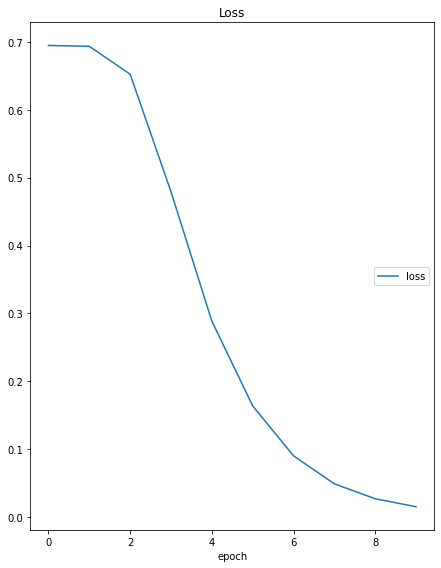

Loss
	loss             	 (min:    0.015, max:    0.695, cur:    0.015)


In [8]:
# Usage of NNRecommender without additional parameters will run GMF model with Adam optimizer and its default parameters
nn_recommender = NNRecommender()
nn_recommender.fit(interactions_df, None, None)

In [9]:
recommendations = nn_recommender.recommend(pd.DataFrame([[1], [2], [3], [4], [5]], columns=['user_id']), items_df, 10)
recommendations = pd.merge(recommendations, items_df, on='item_id', how='left')

display(HTML(recommendations.to_html()))

,user_id,item_id,score,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,68,1.0,WinterVacation,[4-7],Standard,[160-260],[2-2],True
1,1,140,1.0,HighSeason,[4-7],Standard,[260-360],[3-4],True
2,1,61,1.0,OffSeason,[4-7],Nonref,[160-260],[2-2],True
3,1,544,1.0,WinterVacation,[4-7],Nonref,[160-260],[1-1],True
4,1,131,1.0,Easter,[4-7],Standard,[160-260],[1-1],True
5,1,54,1.0,OffSeason,[0-1],Standard,[160-260],[2-2],True
6,1,676,1.0,OffSeason,[4-7],Standard,[0-160],[3-4],True
7,1,292,1.0,LowSeason,[0-1],Standard,[160-260],[3-4],True
8,1,16,1.0,OffSeason,[4-7],Standard,[260-360],[5-inf],True
9,1,24,1.0,OffSeason,[2-3],Standard,[260-360],[3-4],True


# Tuning method

In [20]:
from evaluation_and_testing.testing import evaluate_train_test_split_implicit

seed = 6789

In [10]:
def tune_recommender(recommender_class, interactions_df, items_df, param_space, max_evals=1, show_progressbar=True, seed=6789):
    # Split into train_validation and test sets

    shuffle = np.arange(len(interactions_df))
    rng = np.random.RandomState(seed=seed)
    rng.shuffle(shuffle)
    shuffle = list(shuffle)

    train_test_split = 0.8
    split_index = int(len(interactions_df) * train_test_split)

    train_validation = interactions_df.iloc[shuffle[:split_index]]
    test = interactions_df.iloc[shuffle[split_index:]]

    # Tune

    def loss(tuned_params):
        recommender = recommender_class(seed=seed, **tuned_params)
        hr1, hr3, hr5, hr10, ndcg1, ndcg3, ndcg5, ndcg10 = evaluate_train_test_split_implicit(
            recommender, train_validation, items_df, seed=seed)
        return -hr10

    n_tries = 1
    succeded = False
    try_id = 0
    while not succeded and try_id < n_tries:
        try:
            trials = Trials()
            best_param_set = fmin(loss, space=param_space, algo=tpe.suggest, 
                                  max_evals=max_evals, show_progressbar=show_progressbar, trials=trials, verbose=True)
            succeded = True
        except:
            traceback.print_exc()
            try_id += 1
            
    if not succeded:
        return None
        
    # Validate
    
    recommender = recommender_class(seed=seed, **best_param_set)

    results = [[recommender_class.__name__] + list(evaluate_train_test_split_implicit(recommender, {'train': train_validation, 'test': test}, items_df, seed=seed))]

    results = pd.DataFrame(results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

    display(HTML(results.to_html()))
    
    return best_param_set

## Tuning of the recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Tune your model using the code below. You only need to put the class name of your recommender and choose an appropriate parameter space.

## Empirical Tunning of: epochs number, embedding size, hidden size and batch size

I've tested many configurations but in the end GMF with Adam seems the best so in decided to tune above params with that configuration because doing it with all possible configurations would be too time-consuming.

### Epochs number

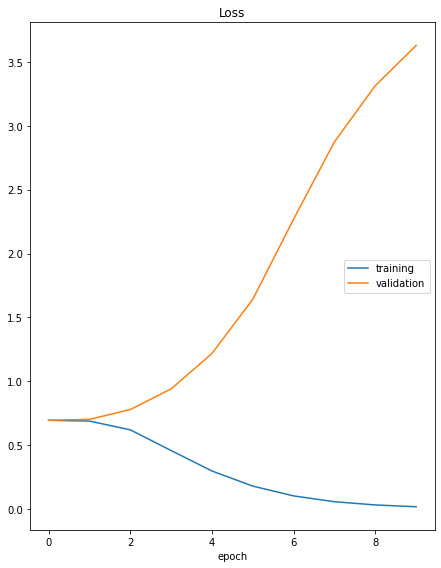

Loss
	training         	 (min:    0.019, max:    0.695, cur:    0.019)
	validation       	 (min:    0.695, max:    3.629, cur:    3.629)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,GMFRecommenderWithAdamOptimizer,0.043788,0.118805,0.160557,0.221656,0.043788,0.086585,0.104031,0.123687


In [11]:
params = {
    'model_name': 'GMF',
    'optimizer_name': 'Adam',
    'n_epochs': 10,
    'train': True
}

gmf_adam_recommender = NNRecommender(**params)
gmf_adam_tts_results = [['GMFRecommenderWithAdamOptimizer'] + list(evaluate_train_test_split_implicit(gmf_adam_recommender, interactions_df, items_df))]
gmf_adam_tts_results = pd.DataFrame(gmf_adam_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(gmf_adam_tts_results.to_html()))

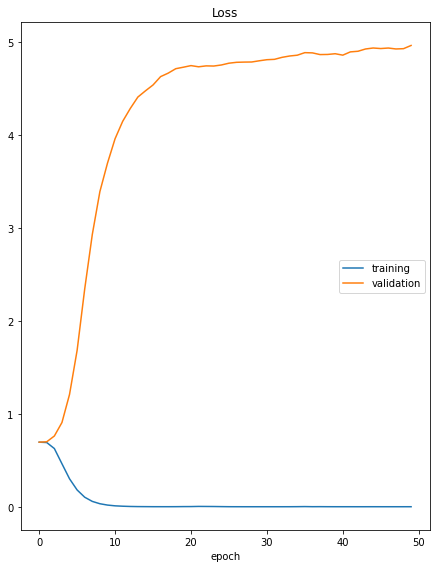

Loss
	training         	 (min:    0.000, max:    0.695, cur:    0.000)
	validation       	 (min:    0.695, max:    4.965, cur:    4.965)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,GMFRecommenderWithAdamOptimizer,0.044128,0.118466,0.160896,0.225051,0.044128,0.086585,0.104294,0.124861


In [12]:
params = {
    'model_name': 'GMF',
    'optimizer_name': 'Adam',
    'n_epochs': 50,
    'train': True
}

gmf_adam_recommender = NNRecommender(**params)
gmf_adam_tts_results = [['GMFRecommenderWithAdamOptimizer'] + list(evaluate_train_test_split_implicit(gmf_adam_recommender, interactions_df, items_df))]
gmf_adam_tts_results = pd.DataFrame(gmf_adam_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(gmf_adam_tts_results.to_html()))

Comparison of these two runs of recommender shows that increasing number of epochs didn't really make a big change. I analysed how loss changed during many runs and found that n_epochs around value of 15 appears to be optimal.

### Embedding size

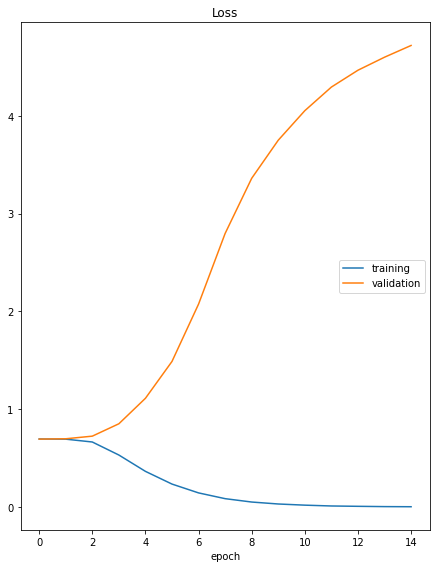

Loss
	training         	 (min:    0.002, max:    0.695, cur:    0.002)
	validation       	 (min:    0.694, max:    4.721, cur:    4.721)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,GMFRecommenderWithAdamOptimizer,0.043788,0.118466,0.160217,0.220638,0.043788,0.08646,0.103906,0.123386


In [13]:
params = {
    'model_name': 'GMF',
    'optimizer_name': 'Adam',
    'n_epochs': 15,
    'embedding_dim': 8,
    'train': True
}

gmf_adam_recommender = NNRecommender(**params)
gmf_adam_tts_results = [['GMFRecommenderWithAdamOptimizer'] + list(evaluate_train_test_split_implicit(gmf_adam_recommender, interactions_df, items_df))]
gmf_adam_tts_results = pd.DataFrame(gmf_adam_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(gmf_adam_tts_results.to_html()))

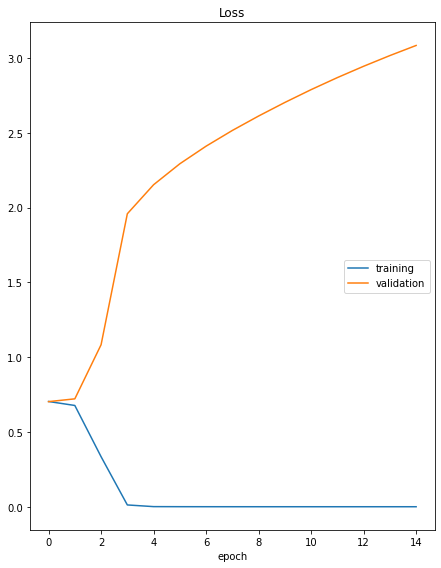

Loss
	training         	 (min:    0.000, max:    0.704, cur:    0.000)
	validation       	 (min:    0.703, max:    3.085, cur:    3.085)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,GMFRecommenderWithAdamOptimizer,0.044128,0.119484,0.161575,0.223693,0.044128,0.087139,0.104716,0.124728


In [14]:
params = {
    'model_name': 'GMF',
    'optimizer_name': 'Adam',
    'n_epochs': 15,
    'embedding_dim': 64,
    'train': True
}

gmf_adam_recommender = NNRecommender(**params)
gmf_adam_tts_results = [['GMFRecommenderWithAdamOptimizer'] + list(evaluate_train_test_split_implicit(gmf_adam_recommender, interactions_df, items_df))]
gmf_adam_tts_results = pd.DataFrame(gmf_adam_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(gmf_adam_tts_results.to_html()))

Increasing embedding size seems to make neural network learn faster and even 15 epochs are too much now but I think it have positive influence on final scores and I will go with embedding_size = 16

### Hidden size

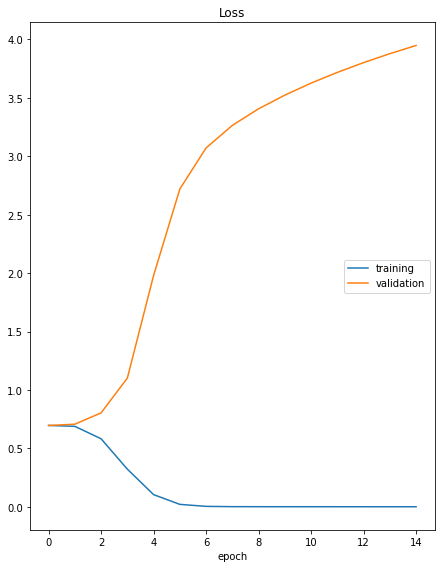

Loss
	training         	 (min:    0.000, max:    0.696, cur:    0.000)
	validation       	 (min:    0.696, max:    3.949, cur:    3.949)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,GMFRecommenderWithAdamOptimizer,0.043788,0.118805,0.160557,0.221656,0.043788,0.086674,0.104135,0.123761


In [15]:
params = {
    'model_name': 'GMF',
    'optimizer_name': 'Adam',
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 8,
    'train': True
}

gmf_adam_recommender = NNRecommender(**params)
gmf_adam_tts_results = [['GMFRecommenderWithAdamOptimizer'] + list(evaluate_train_test_split_implicit(gmf_adam_recommender, interactions_df, items_df))]
gmf_adam_tts_results = pd.DataFrame(gmf_adam_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(gmf_adam_tts_results.to_html()))

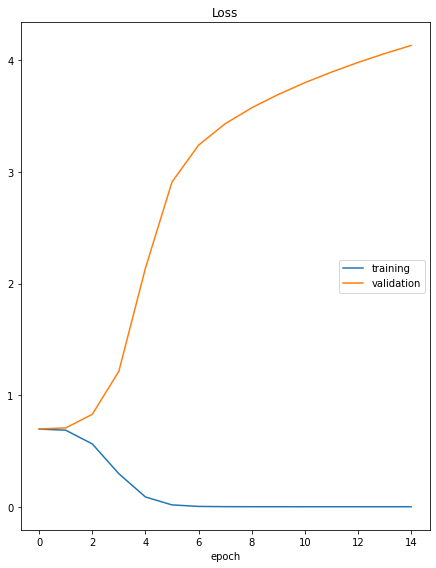

Loss
	training         	 (min:    0.000, max:    0.696, cur:    0.000)
	validation       	 (min:    0.698, max:    4.135, cur:    4.135)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,GMFRecommenderWithAdamOptimizer,0.043788,0.118466,0.160896,0.22539,0.043788,0.086416,0.104139,0.124734


In [16]:
params = {
    'model_name': 'GMF',
    'optimizer_name': 'Adam',
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 128,
    'train': True
}

gmf_adam_recommender = NNRecommender(**params)
gmf_adam_tts_results = [['GMFRecommenderWithAdamOptimizer'] + list(evaluate_train_test_split_implicit(gmf_adam_recommender, interactions_df, items_df))]
gmf_adam_tts_results = pd.DataFrame(gmf_adam_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(gmf_adam_tts_results.to_html()))

To be honest I didn't notice any crucial changes related to hidden_dim value so I will keep it equal to embedding size which is 16.

### Batch size

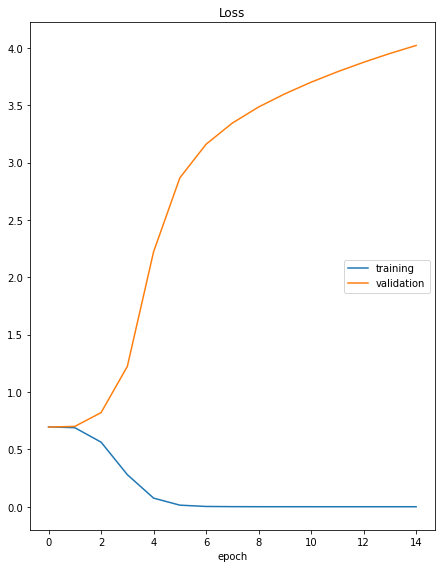

Loss
	training         	 (min:    0.000, max:    0.696, cur:    0.000)
	validation       	 (min:    0.695, max:    4.020, cur:    4.020)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,GMFRecommenderWithAdamOptimizer,0.043788,0.118466,0.161914,0.222335,0.043788,0.086416,0.104533,0.123953


In [17]:
params = {
    'model_name': 'GMF',
    'optimizer_name': 'Adam',
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 16,
    'batch_size': 64,
    'train': True
}

gmf_adam_recommender = NNRecommender(**params)
gmf_adam_tts_results = [['GMFRecommenderWithAdamOptimizer'] + list(evaluate_train_test_split_implicit(gmf_adam_recommender, interactions_df, items_df))]
gmf_adam_tts_results = pd.DataFrame(gmf_adam_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(gmf_adam_tts_results.to_html()))

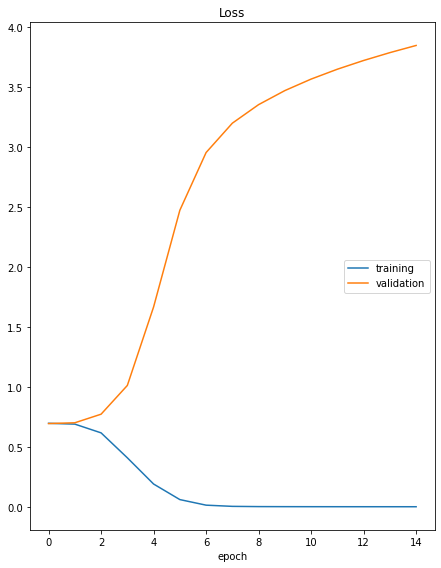

Loss
	training         	 (min:    0.000, max:    0.695, cur:    0.000)
	validation       	 (min:    0.693, max:    3.845, cur:    3.845)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,GMFRecommenderWithAdamOptimizer,0.043788,0.119145,0.161575,0.223354,0.043788,0.086844,0.104567,0.124037


In [18]:
params = {
    'model_name': 'GMF',
    'optimizer_name': 'Adam',
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 16,
    'batch_size': 128,
    'train': True
}

gmf_adam_recommender = NNRecommender(**params)
gmf_adam_tts_results = [['GMFRecommenderWithAdamOptimizer'] + list(evaluate_train_test_split_implicit(gmf_adam_recommender, interactions_df, items_df))]
gmf_adam_tts_results = pd.DataFrame(gmf_adam_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(gmf_adam_tts_results.to_html()))

## Summary for tunning with optimizer params:

After testing different configurations I decided to run recommenders with these parameters:

- n_epochs: 15
- embedding_dim: 16
- hidden_dim: 16
- batch_size: 128

I'm sure they might be better but trying over and over was really time-consuming and didn't give big differences

## GMFRecommender

### Adam optimizer params tunning

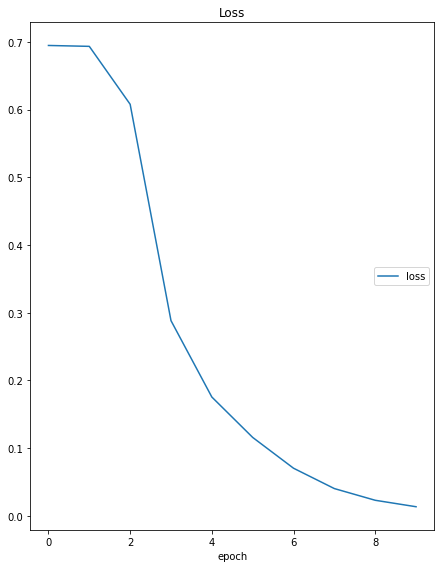

Loss
	loss             	 (min:    0.013, max:    0.695, cur:    0.013)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,GMFRecommender,0.046843,0.123897,0.166667,0.229464,0.046843,0.090837,0.108706,0.128955


Best parameters:
{'lr': 0.012917521684392056, 'n_neg_per_pos': 9.0, 'weight_decay': 0.0004880694352535569}


In [21]:
param_space = {
    'model_name': 'GMF',
    'optimizer_name': 'Adam',
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 16,
    'batch_size': 128,
    'train': True,
    #
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 1, 10, 1),
    'lr': hp.loguniform('lr', np.log(0.001), np.log(0.1)),
    'weight_decay': hp.loguniform('weight_decay', np.log(0.000001), 1)
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df, param_space, max_evals=10, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

### SGD optimizer params tunning

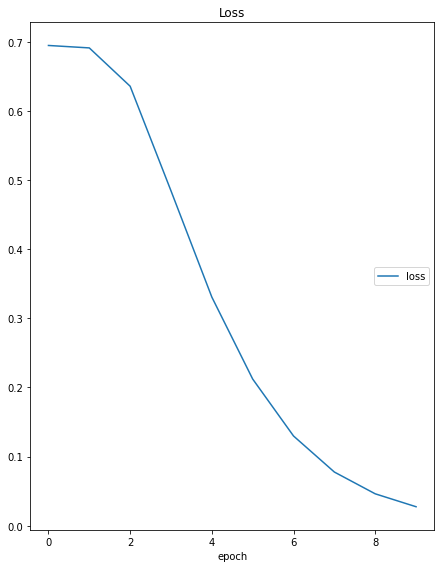

Loss
	loss             	 (min:    0.027, max:    0.695, cur:    0.027)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,GMFRecommender,0.044128,0.120163,0.166667,0.229464,0.044128,0.087612,0.106896,0.126978


Best parameters:
{'lr': 0.06531480975542919, 'n_neg_per_pos': 5.0, 'weight_decay': 0.2946748369198841}


In [22]:
param_space = {
    'model_name': 'GMF',
    'optimizer_name': 'SGD',
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 16,
    'batch_size': 128,
    'train': True,
    #
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 1, 10, 1),
    'lr': hp.loguniform('lr', np.log(0.001), np.log(0.1)),
    'weight_decay': hp.loguniform('weight_decay', np.log(0.000001), 1)
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df, param_space, max_evals=10, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

### ASGD optimizer params tunning

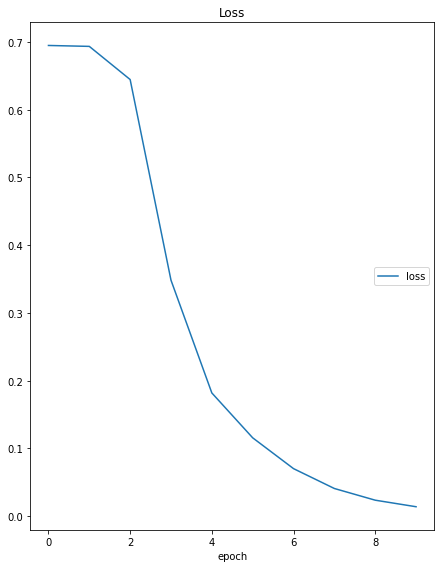

Loss
	loss             	 (min:    0.014, max:    0.695, cur:    0.014)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,GMFRecommender,0.044807,0.123218,0.165988,0.234895,0.044807,0.089657,0.107511,0.129744


Best parameters:
{'lr': 0.003667314979653311, 'n_neg_per_pos': 9.0, 'weight_decay': 2.108374768977645e-06}


In [23]:
param_space = {
    'model_name': 'GMF',
    'optimizer_name': 'ASGD',
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 16,
    'batch_size': 128,
    'train': True,
    #
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 1, 10, 1),
    'lr': hp.loguniform('lr', np.log(0.001), np.log(0.1)),
    'weight_decay': hp.loguniform('weight_decay', np.log(0.000001), 1)
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df, param_space, max_evals=10, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

## MLPRecommender

### Adam optimizer params tunning

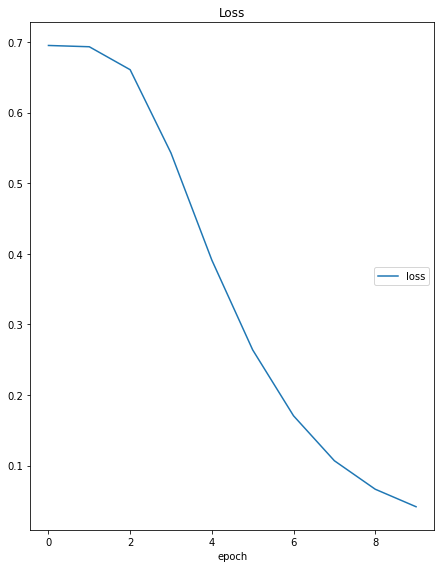

Loss
	loss             	 (min:    0.042, max:    0.695, cur:    0.042)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,MLPRecommender,0.044467,0.120163,0.162933,0.225051,0.044467,0.087648,0.105518,0.125328


Best parameters:
{'lr': 0.0030235236934055103, 'n_neg_per_pos': 5.0, 'weight_decay': 1.1557039690286527e-06}


In [24]:
param_space = {
    'model_name': 'MLP',
    'optimizer_name': 'Adam',
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 16,
    'batch_size': 128,
    'train': True,
    #
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 1, 10, 1),
    'lr': hp.loguniform('lr', np.log(0.001), np.log(0.1)),
    'weight_decay': hp.loguniform('weight_decay', np.log(0.000001), 1)
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df, param_space, max_evals=10, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

### SGD optimizer params tunning

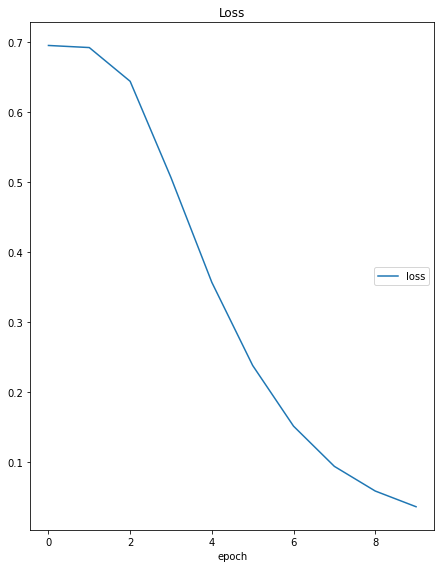

Loss
	loss             	 (min:    0.036, max:    0.695, cur:    0.036)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,MLPRecommender,0.044128,0.118805,0.16463,0.223014,0.044128,0.086755,0.105792,0.124544


Best parameters:
{'lr': 0.0011111217679204484, 'n_neg_per_pos': 5.0, 'weight_decay': 0.4723768051577314}


In [25]:
param_space = {
    'model_name': 'MLP',
    'optimizer_name': 'SGD',
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 16,
    'batch_size': 128,
    'train': True,
    #
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 1, 10, 1),
    'lr': hp.loguniform('lr', np.log(0.001), np.log(0.1)),
    'weight_decay': hp.loguniform('weight_decay', np.log(0.000001), 1)
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df, param_space, max_evals=10, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

### ASGD optimizer params tunning

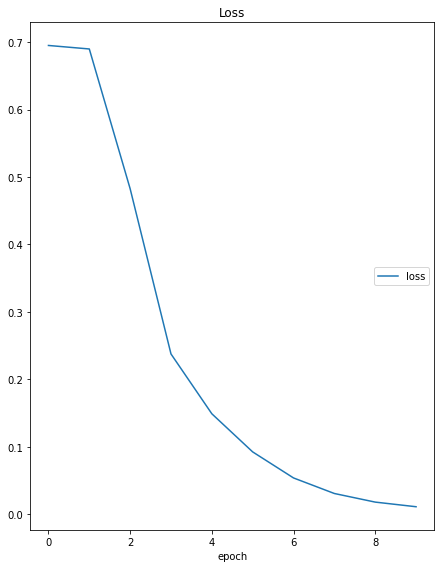

Loss
	loss             	 (min:    0.011, max:    0.695, cur:    0.011)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,MLPRecommender,0.044467,0.122878,0.167346,0.228445,0.044467,0.089228,0.107769,0.127531


Best parameters:
{'lr': 0.012718672704293102, 'n_neg_per_pos': 9.0, 'weight_decay': 0.09871958775506479}


In [26]:
param_space = {
    'model_name': 'MLP',
    'optimizer_name': 'ASGD',
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 16,
    'batch_size': 128,
    'train': True,
    #
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 1, 10, 1),
    'lr': hp.loguniform('lr', np.log(0.001), np.log(0.1)),
    'weight_decay': hp.loguniform('weight_decay', np.log(0.000001), 1)
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df, param_space, max_evals=10, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

## NeuMFRecommender

### Adam optimizer params tunning

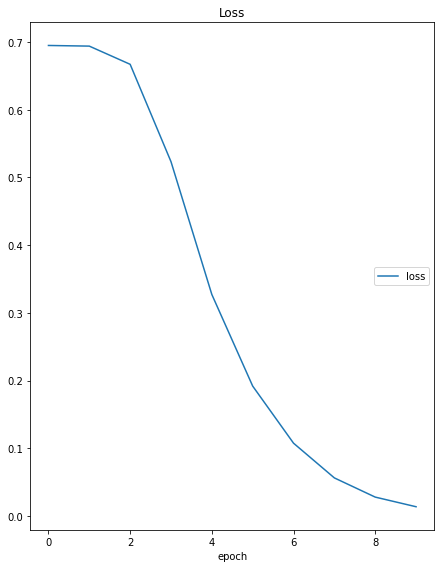

Loss
	loss             	 (min:    0.014, max:    0.695, cur:    0.014)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NeuMFRecommender,0.044467,0.120842,0.164969,0.230482,0.044467,0.088032,0.106472,0.127464


Best parameters:
{'lr': 0.003380903379083977, 'n_neg_per_pos': 6.0, 'weight_decay': 0.00030620763243595573}


In [27]:
param_space = {
    'model_name': 'NeuMF',
    'optimizer_name': 'Adam',
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 16,
    'batch_size': 128,
    'train': True,
    #
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 1, 10, 1),
    'lr': hp.loguniform('lr', np.log(0.001), np.log(0.1)),
    'weight_decay': hp.loguniform('weight_decay', np.log(0.000001), 1)
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df, param_space, max_evals=10, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

### SGD optimizer params tunning

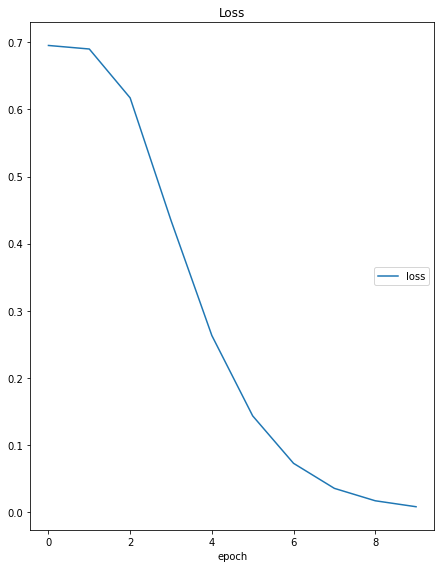

Loss
	loss             	 (min:    0.008, max:    0.695, cur:    0.008)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NeuMFRecommender,0.043788,0.119484,0.161914,0.223354,0.043788,0.087014,0.104752,0.124473


Best parameters:
{'lr': 0.0028756423085441627, 'n_neg_per_pos': 3.0, 'weight_decay': 0.0007032144351924933}


In [28]:
param_space = {
    'model_name': 'NeuMF',
    'optimizer_name': 'SGD',
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 16,
    'batch_size': 128,
    'train': True,
    #
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 1, 10, 1),
    'lr': hp.loguniform('lr', np.log(0.001), np.log(0.1)),
    'weight_decay': hp.loguniform('weight_decay', np.log(0.000001), 1)
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df, param_space, max_evals=10, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

### ASGD optimizer params tunning

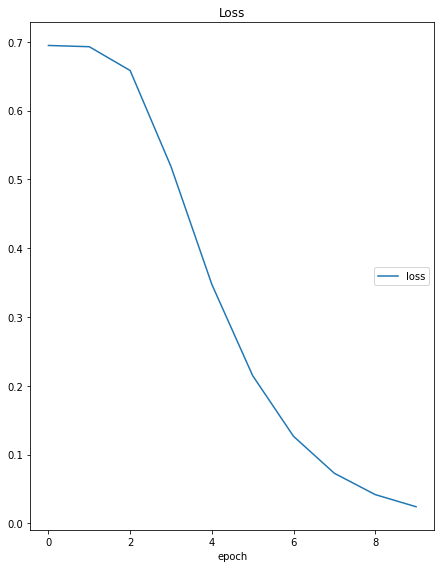

Loss
	loss             	 (min:    0.024, max:    0.695, cur:    0.024)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NeuMFRecommender,0.044128,0.119145,0.161575,0.224372,0.044128,0.086969,0.104693,0.124792


Best parameters:
{'lr': 0.0011519271766241772, 'n_neg_per_pos': 5.0, 'weight_decay': 2.4598198962718836e-05}


In [29]:
param_space = {
    'model_name': 'NeuMF',
    'optimizer_name': 'ASGD',
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 16,
    'batch_size': 128,
    'train': True,
    #
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 1, 10, 1),
    'lr': hp.loguniform('lr', np.log(0.001), np.log(0.1)),
    'weight_decay': hp.loguniform('weight_decay', np.log(0.000001), 1)
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df, param_space, max_evals=10, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

# Final evaluation

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Run the final evaluation of your recommender and present its results against the Amazon and Netflix recommenders' results. You just need to give the class name of your recommender and its tuned parameters below.

It's optional, but for better effect you can include here the results from all recommenders created during in this class.

## GMFRecommender

### Adam Optimizer

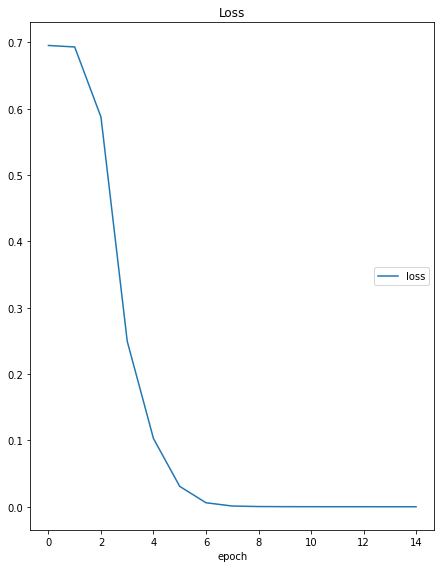

Loss
	loss             	 (min:    0.000, max:    0.695, cur:    0.000)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,GMFRecommenderWithAdamOptimizer,0.046504,0.123897,0.166327,0.234895,0.046504,0.0908,0.108524,0.130622


In [32]:
params = {
    'model_name': 'GMF',
    'optimizer_name': 'Adam',
    'train': False,
    #
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 16,
    'batch_size': 128,
    #
    'lr': 0.012917521684392056, 
    'n_neg_per_pos': 9.0, 
    'weight_decay': 0.0004880694352535569
}

gmf_adam_recommender = NNRecommender(**params)
gmf_adam_tts_results = [['GMFRecommenderWithAdamOptimizer'] + list(evaluate_train_test_split_implicit(gmf_adam_recommender, interactions_df, items_df))]
gmf_adam_tts_results = pd.DataFrame(gmf_adam_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(gmf_adam_tts_results.to_html()))

### SGD Optimizer

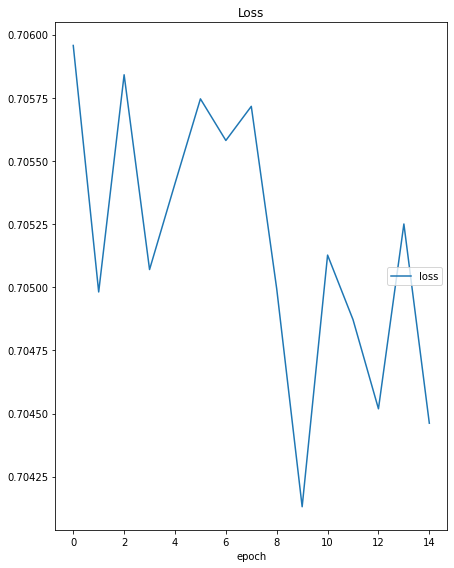

Loss
	loss             	 (min:    0.704, max:    0.706, cur:    0.704)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,GMFRecommenderWithSGDOptimizer,0.043788,0.118126,0.163612,0.220299,0.043788,0.086246,0.105136,0.123396


In [33]:
params = {
    'model_name': 'GMF',
    'optimizer_name': 'SGD',
    'train': False,
    #
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 16,
    'batch_size': 128,
    #
    'lr': 0.06531480975542919, 
    'n_neg_per_pos': 5.0, 
    'weight_decay': 0.2946748369198841
}

gmf_sgd_recommender = NNRecommender(**params)
gmf_sgd_tts_results = [['GMFRecommenderWithSGDOptimizer'] + list(evaluate_train_test_split_implicit(gmf_sgd_recommender, interactions_df, items_df))]
gmf_sgd_tts_results = pd.DataFrame(gmf_sgd_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(gmf_sgd_tts_results.to_html()))

### ASGD Optimizer

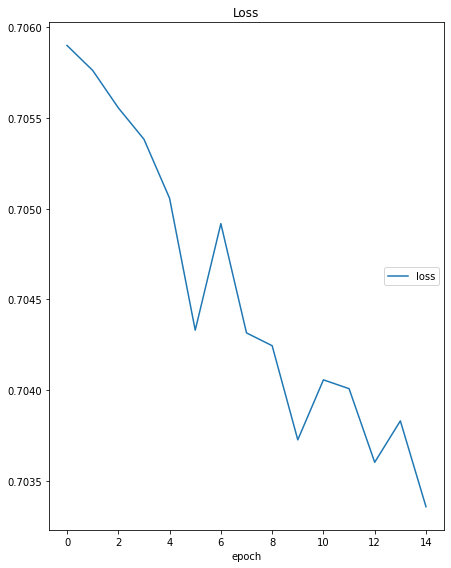

Loss
	loss             	 (min:    0.703, max:    0.706, cur:    0.703)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,GMFRecommenderWithASGDOptimizer,0.043788,0.118466,0.163612,0.220638,0.043788,0.08646,0.105219,0.123304


In [34]:
params = {
    'model_name': 'GMF',
    'optimizer_name': 'ASGD',
    'train': False,
    #
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 16,
    'batch_size': 128,
    #
    'lr': 0.003667314979653311, 
    'n_neg_per_pos': 9.0, 
    'weight_decay': 2.108374768977645e-06
}

gmf_asgd_recommender = NNRecommender(**params)
gmf_asgd_tts_results = [['GMFRecommenderWithASGDOptimizer'] + list(evaluate_train_test_split_implicit(gmf_asgd_recommender, interactions_df, items_df))]
gmf_asgd_tts_results = pd.DataFrame(gmf_asgd_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(gmf_asgd_tts_results.to_html()))

## MLP Recommender

### Adam Optimizer

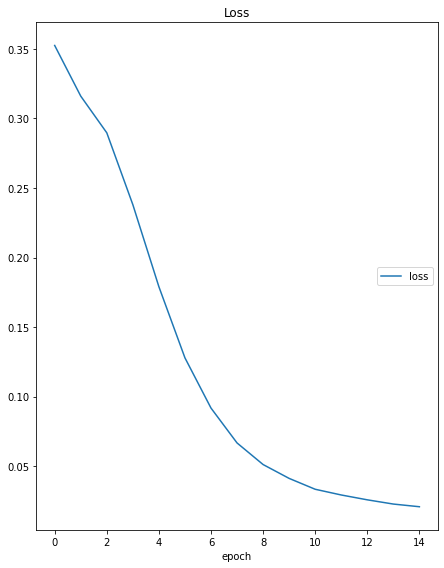

Loss
	loss             	 (min:    0.021, max:    0.352, cur:    0.021)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,MLPRecommenderWithAdamOptimizer,0.046504,0.124576,0.168024,0.23184,0.046504,0.09114,0.109272,0.129782


In [35]:
params = {
    'model_name': 'MLP',
    'optimizer_name': 'Adam',
    'train': False,
    #
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 16,
    'batch_size': 128,
    #
    'lr': 0.0030235236934055103, 
    'n_neg_per_pos': 5.0, 
    'weight_decay': 1.1557039690286527e-06
}

mlp_adam_recommender = NNRecommender(**params)
mlp_adam_tts_results = [['MLPRecommenderWithAdamOptimizer'] + list(evaluate_train_test_split_implicit(mlp_adam_recommender, interactions_df, items_df))]
mlp_adam_tts_results = pd.DataFrame(mlp_adam_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(mlp_adam_tts_results.to_html()))

### SGD Optimizer

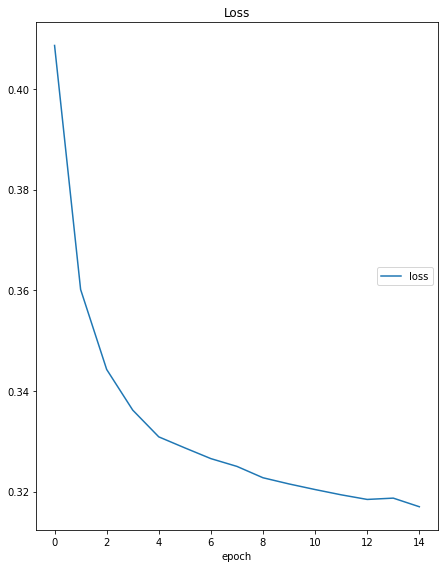

Loss
	loss             	 (min:    0.317, max:    0.409, cur:    0.317)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,MLPRecommenderWithSGDOptimizer,0.047183,0.129328,0.174813,0.244399,0.047183,0.094033,0.113087,0.135149


In [36]:
params = {
    'model_name': 'MLP',
    'optimizer_name': 'SGD',
    'train': False,
    #
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 16,
    'batch_size': 128,
    #
    'lr': 0.0011111217679204484, 
    'n_neg_per_pos': 5.0, 
    'weight_decay': 0.4723768051577314
}

mlp_sgd_recommender = NNRecommender(**params)
mlp_sgd_tts_results = [['MLPRecommenderWithSGDOptimizer'] + list(evaluate_train_test_split_implicit(mlp_sgd_recommender, interactions_df, items_df))]
mlp_sgd_tts_results = pd.DataFrame(mlp_sgd_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(mlp_sgd_tts_results.to_html()))

### ASGD Optimizer

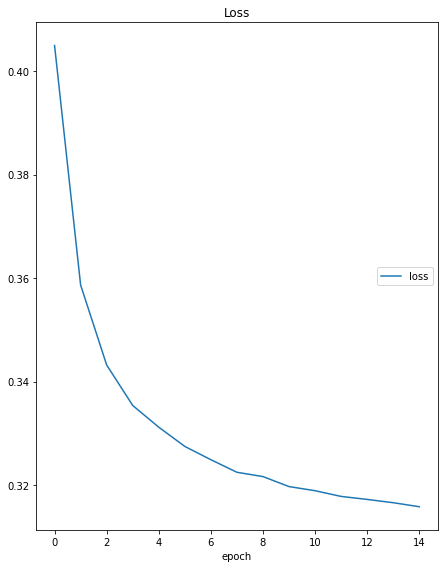

Loss
	loss             	 (min:    0.316, max:    0.405, cur:    0.316)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,MLPRecommenderWithASGDOptimizer,0.049219,0.129667,0.177529,0.245757,0.049219,0.095132,0.115046,0.136897


In [37]:
params = {
    'model_name': 'MLP',
    'optimizer_name': 'ASGD',
    'train': False,
    #
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 16,
    'batch_size': 128,
    #
    'lr': 0.012718672704293102, 
    'n_neg_per_pos': 9.0, 
    'weight_decay': 0.09871958775506479
}

mlp_asgd_recommender = NNRecommender(**params)
mlp_asgd_tts_results = [['MLPRecommenderWithASGDOptimizer'] + list(evaluate_train_test_split_implicit(mlp_sgd_recommender, interactions_df, items_df))]
mlp_asgd_tts_results = pd.DataFrame(mlp_asgd_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(mlp_asgd_tts_results.to_html()))

## NeuMF Recommender

### Adam Optimizer

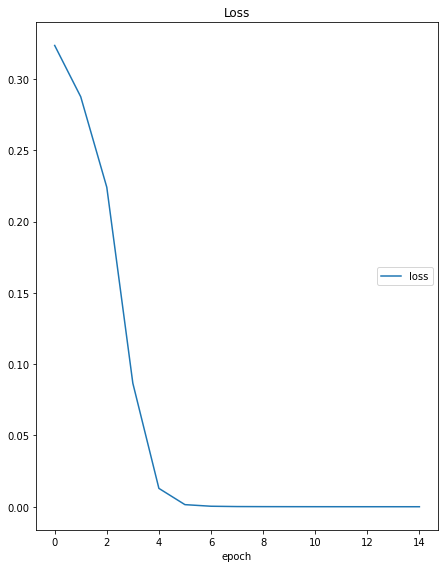

Loss
	loss             	 (min:    0.000, max:    0.324, cur:    0.000)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NeuMFRecommenderAdamOptimizer,0.04854,0.126612,0.17074,0.239986,0.04854,0.093043,0.111438,0.133696


In [38]:
params = {
    'model_name': 'NeuMF',
    'optimizer_name': 'Adam',
    'train': False,
    #
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 16,
    'batch_size': 128,
    #
    'lr': 0.003380903379083977, 
    'n_neg_per_pos': 6.0, 
    'weight_decay': 0.00030620763243595573
}

neumf_adam_recommender = NNRecommender(**params)
neumf_adam_tts_results = [['NeuMFRecommenderAdamOptimizer'] + list(evaluate_train_test_split_implicit(neumf_adam_recommender, interactions_df, items_df))]
neumf_adam_tts_results = pd.DataFrame(neumf_adam_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(neumf_adam_tts_results.to_html()))

### SGD Optimizer

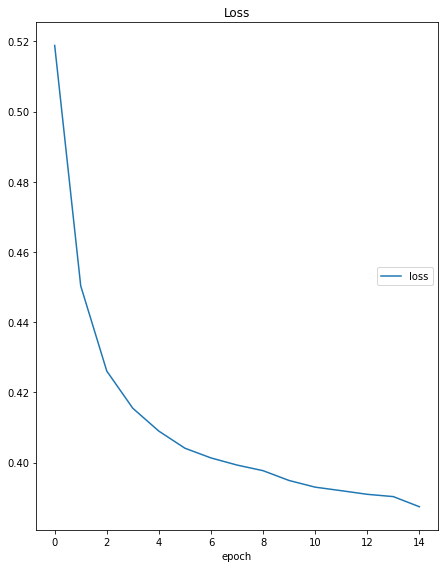

Loss
	loss             	 (min:    0.387, max:    0.519, cur:    0.387)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NeuMFRecommenderSGDOptimizer,0.046843,0.127291,0.175153,0.243381,0.046843,0.092889,0.112833,0.134746


In [39]:
params_space = {
    'model_name': 'NeuMF',
    'optimizer_name': 'SGD',
    'train': False,
    #
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 16,
    'batch_size': 128,
    #
    'lr': 0.0028756423085441627, 
    'n_neg_per_pos': 3.0, 
    'weight_decay': 0.0007032144351924933
}

neumf_sgd_recommender = NNRecommender(**params_space)
neumf_sgd_tts_results = [['NeuMFRecommenderSGDOptimizer'] + list(evaluate_train_test_split_implicit(neumf_sgd_recommender, interactions_df, items_df))]
neumf_sgd_tts_results = pd.DataFrame(neumf_sgd_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(neumf_sgd_tts_results.to_html()))

### ASGD Optimizer

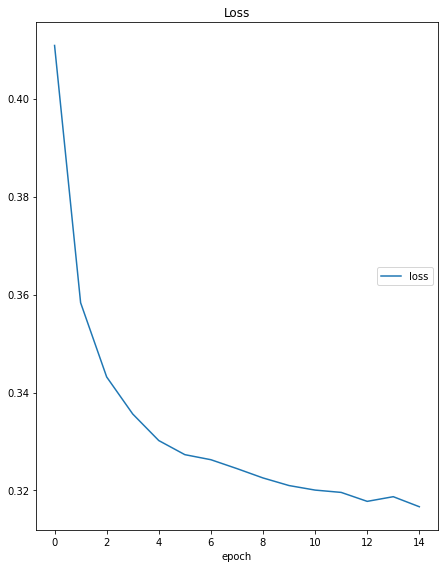

Loss
	loss             	 (min:    0.317, max:    0.411, cur:    0.317)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NeuMFRecommenderASGDOptimizer,0.046843,0.12797,0.177189,0.24372,0.046843,0.093184,0.113579,0.135015


In [41]:
params = {
    'model_name': 'NeuMF',
    'optimizer_name': 'ASGD',
    'train': False,
    #
    'n_epochs': 15,
    'embedding_dim': 16,
    'hidden_dim': 16,
    'batch_size': 128,
    #
    'lr': 0.0011519271766241772, 
    'n_neg_per_pos': 5.0, 
    'weight_decay': 2.4598198962718836e-05
}

neumf_asgd_recommender = NNRecommender(**params)
neumf_asgd_tts_results = [['NeuMFRecommenderASGDOptimizer'] + list(evaluate_train_test_split_implicit(neumf_asgd_recommender, interactions_df, items_df))]
neumf_asgd_tts_results = pd.DataFrame(neumf_asgd_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(neumf_asgd_tts_results.to_html()))

### Amazon Recommender

In [30]:
amazon_recommender = AmazonRecommender()
amazon_tts_results = [['AmazonRecommender'] + list(evaluate_train_test_split_implicit(amazon_recommender, interactions_df, items_df))]
amazon_tts_results = pd.DataFrame(amazon_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,AmazonRecommender,0.044128,0.118805,0.160557,0.223693,0.044128,0.086755,0.104216,0.124468


### Netflix Recommender

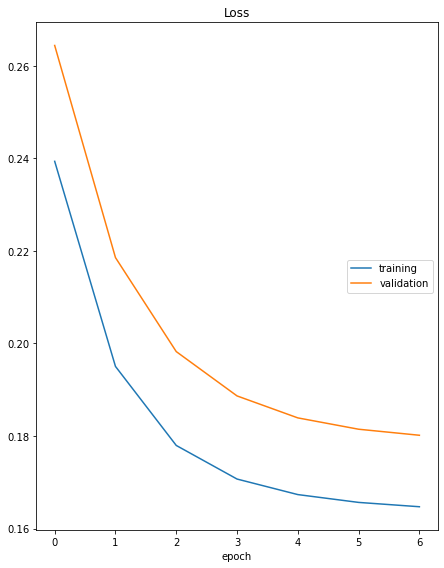

Loss
	training         	 (min:    0.165, max:    0.239, cur:    0.165)
	validation       	 (min:    0.180, max:    0.264, cur:    0.180)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NetflixRecommender,0.044128,0.119145,0.161236,0.224033,0.044128,0.086925,0.104532,0.124597


In [31]:
netflix_recommender = NetflixRecommender(embedding_dim=8, n_epochs=10, print_type='live')
netflix_tts_results = [['NetflixRecommender'] + list(evaluate_train_test_split_implicit(netflix_recommender, interactions_df, items_df))]
netflix_tts_results = pd.DataFrame(netflix_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_tts_results.to_html()))

# Comparison

In [42]:
tts_results = pd.concat([
    gmf_adam_tts_results,
    gmf_sgd_tts_results,
    gmf_asgd_tts_results,
    mlp_adam_tts_results,
    mlp_sgd_tts_results,
    mlp_asgd_tts_results,
    neumf_adam_tts_results,
    neumf_sgd_tts_results,
    neumf_asgd_tts_results,
    amazon_tts_results, 
    netflix_tts_results
]).reset_index(drop=True)

tts_results = tts_results.sort_values(by = ['HR@10']).reset_index(drop=True)
display(HTML(tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,GMFRecommenderWithSGDOptimizer,0.043788,0.118126,0.163612,0.220299,0.043788,0.086246,0.105136,0.123396
1,GMFRecommenderWithASGDOptimizer,0.043788,0.118466,0.163612,0.220638,0.043788,0.086460,0.105219,0.123304
2,AmazonRecommender,0.044128,0.118805,0.160557,0.223693,0.044128,0.086755,0.104216,0.124468
3,NetflixRecommender,0.044128,0.119145,0.161236,0.224033,0.044128,0.086925,0.104532,0.124597
4,MLPRecommenderWithAdamOptimizer,0.046504,0.124576,0.168024,0.231840,0.046504,0.091140,0.109272,0.129782
5,GMFRecommenderWithAdamOptimizer,0.046504,0.123897,0.166327,0.234895,0.046504,0.090800,0.108524,0.130622
6,NeuMFRecommenderAdamOptimizer,0.048540,0.126612,0.170740,0.239986,0.048540,0.093043,0.111438,0.133696
7,NeuMFRecommenderSGDOptimizer,0.046843,0.127291,0.175153,0.243381,0.046843,0.092889,0.112833,0.134746
8,NeuMFRecommenderASGDOptimizer,0.046843,0.127970,0.177189,0.243720,0.046843,0.093184,0.113579,0.135015
9,MLPRecommenderWithSGDOptimizer,0.047183,0.129328,0.174813,0.244399,0.047183,0.094033,0.113087,0.135149


# Summary

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Write a summary of your experiments. What worked well and what did not? What are your thoughts how could you possibly further improve the model?

To be honest I've never been a huge fan of neural network but I considered this project as an opportunity to learn more about them and open my mind on technology that is crucial in our time.

#### Results of my experiment with different models and optimizers combinations

It's pretty awesome to compare all the results and analyse how performance was increasing with different model and optimizer setup. When I was doing quick tests before final evaluation I thought that GMF with Adam will be the best but it's not. In general it looks like MLP and NeuMF architectures are doing better than GMF and what's more Adam optimizer is not really the best as models with it are worse than with SGD and ASGD. It's very interesting how tunned parameters differs for different setup of model and optimizer and how loss curvers differs. However with additional checks I did it seems that Adam optimizer is more stable than SGD and ASGD but they are still better when it comes to final evaluation. I made what I planned with comparing these different recommenders and I consider it as a good entry point for analysing how to use best possible optimizer for particular model and how neural network architecture is connected to optimizer work. I wonder if it's possible to give real reasons for choosing one optimizer over another by only analysing neural network architecture... In the end MLP with ASGD Optimizer is the winner!

#### What worked well

I am pleased with how I managed to create a base neural network recommender class exactly how I imagined at first place. I wanted to make it easy to extend with other models and optimizers and basically everything but with usage of the given framework at the same time. There is no problem to add new model or optimizer and it requires only few changes. Implementation of MLP, GMF, NeuMF models wasn't very hard because I had knowledge how to do it from lectures. I spent a lot of time on reading about optimizers, it's very interesting what algorithm stants behind them and how they differs. My little experiment shows how results given by different combinations of models and optimizers differs. I think the final results are also fine so everything workout pretty well.  

#### ... and what did not

I think that the tunning of optimizers parameters might be much better because I struggled how to define param spaces for most of them and in the end I tunned number of negative interactions, learning rates and weight decays only but I prepared everything for using all optional parameters of optimizers and tunning them. I spent time on searching for best embedding dimension, hidden dimension, batch sizes and epoch number but the results were not what I expected, for me it was very hard to get reasonable values ​​of these parameters and better results. There was no big improvements so I stayed with values that are defaults in recommender class and didn't include them in final version of notebook as it's pretty big already and I wanted to focus on models and optimizers comparison.

I am also sad that I didn't make hybrid version of recommender because I had an idea to make it configurable also and easily run base recommender as neural network only or as hybrid.
Unfortunately, other subjects at the university take life energy and time which I would need to do this...

#### Model improvement

It would definitely be worth checking how the combinations of models and optimizers I have tested would work in the hybrid recommender. I'm very curious about overall impact of using numerical item and user features... I wonder if hybrid recommender is always better or it depends mostly on the dataset... I wonder how it would work on this dataset and I hope I will find some time to extend this project with hybrid recommender during the holidays.

I also have a feeling that the embedding dimension, hidden dimension and batch sizes might be slightly better than these used by me as default so I would consider finding the best values of these parameters as improvement too because I feel that my empirical tunning might be done better.

#### General feeling

Both projects were great and there was no subject throughout the whole studies that would enter any branch of computer science in such detail. For one person it will be an advantage, for the other a disadvantage. I personally wasn't interested in these topics before the recommendation systems class and at the beginning I was overwhelmed by the amount of information provided in class but now I can say that it was great experience and I'm glad that I had the opportunity to attend these classes.

Thanks for the knowledge!